Modelos para o crescimento tumoral

In [62]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d


Passo 1: Capturar os dados do gráfico.

In [63]:
experimental_data = pd.read_csv('new_Default_Dataset.csv')
print(experimental_data.iloc[:,1])
print(experimental_data.iloc[:,1].size)

0      4563.953496
1      6356.763423
2     12295.151020
3     24958.513210
4     47808.045920
5     92459.913580
6    191328.092800
7    239610.948900
8    247438.793800
9    250635.841800
Name:  4462.212901, dtype: float64
10


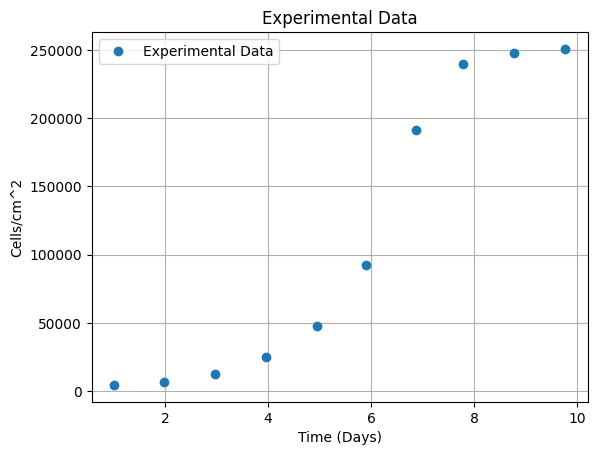

In [64]:
# Plot the experimental data
plt.plot(experimental_data.iloc[:,0], experimental_data.iloc[:,1], 'o', label='Experimental Data')
plt.xlabel('Time (Days)')
plt.ylabel('Cells/cm^2')
plt.title('Experimental Data')
plt.legend()
plt.grid()
plt.show()


In [65]:
def df_to_latex(df, caption="Tabela", label="tab:tabela", float_format="%.2f"):
    """
    Converte um DataFrame do pandas em uma tabela LaTeX.
    
    Parâmetros:
    df : pandas.DataFrame
        O DataFrame a ser convertido
    caption : str
        Legenda da tabela
    label : str
        Rótulo da tabela para referência cruzada
    float_format : str
        Formato dos números de ponto flutuante
    """
    
    # Converte o DataFrame para LaTeX
    latex_table = df.to_latex(
        index=False,  # Remove o índice do DataFrame
        float_format=float_format,  # Formato dos números
        column_format='c' * len(df.columns),  # Centraliza todas as colunas
        escape=False,  # Permite caracteres especiais
    )
    
    # Personaliza a tabela adicionando elementos LaTeX
    latex_output = (
        "\\begin{table}[h]\n"
        "\\centering\n"
        f"\\caption{{{caption}}}\n"
        f"\\label{{{label}}}\n"
        f"{latex_table}"
        "\\end{table}"
    )
    
    return latex_output

if __name__ == "__main__":
        
    # Converte para LaTeX
    latex_result = df_to_latex(
        df = experimental_data,
        caption = "Tabela de Dados Experimentais obtidos com o WebPlotDigitizer",
        label="tab:ex1_data",
        float_format="%.1f"
    )
    
    # print(latex_result)
    
    with open('tabela.tex', 'w') as f:
        f.write(latex_result)

Passo 2: Estabelecer hipóteses

Considera-se o crescimento de células tumorais onde:

1. Modelo de crescimento exponencial

* o tumor é representado por um único tipo de célula (população homogênea);
* não há imigração ou emigração (populações que começam em zero permanecem em zero (t), sistema fechado);
* método determinístico (ignora a chance de efeitos estocásticos);
* não há variação espacial e temporal;
* não há mutações (todas as células crescem igualmente) ou migrações;
* crescimento avascular;
* a taxa de crescimento r reduz com o aumento da população;
* sem resposta imune;
* a densidade de células é representada por N(t).

2. Modelo de crescimento logístico

* o tumor é representado por um único tipo de célula (população homogênea);
* não há imigração ou emigração (populações que começam em zero permanecem em zero (t));
* método determinístico (ignora a chance de efeitos estocásticos);
* não há variação espacial e temporal;
* não há mutações (todas as células crescem igualmente) ou migrações;
* crescimento avascular;
* o crescimento é limitado pela disponibilidade de recursos;
* a taxa de crescimento r reduz com o aumento da população;
* competição direta entre células por recursos;
* sem resposta imune;
* a densidade de células é representada por N(t).

2. Modelo de crescimento de Gompertz

* o tumor é representado por um único tipo de célula;
* não há variação espacial;
* não há mutações (todas as células crescem igualmente) ou migrações;
* não há competição direta;
* crescimento avascular;
* o crescimento é limitado pela disponibilidade de recursos;
* a taxa de crescimento r **reduz** devido a fatores internos (como *senescência celular* , etc);
* sem resposta imune;
* a densidade de células é representada por N(t).


*senescência celular*: processo em que as células param de se dividir, mas não morrem.

In [92]:
# modelos
def malthus_growth_model(t:list[int], r:float, N0:float)->list[float]:
    # ref: doi: 10.5540/tcam.2021.022.03.00495
    return N0 * np.exp(r * t)

def malthus_growth_model_r_double(t:list[int], r_double:float, N0:float)->list[float]:
    # ref: exercício 1.0    
    return N0 * np.exp(r_double * t)

def logistic_growth_model(t:list[int], r:float, N0:float, K:float)->list[float]:
    # ref: doi: 10.5540/tcam.2021.022.03.00495
    return  (N0 * np.exp(r * t))/(1 - (N0/K * (1 - np.exp(r * t))))

def modelo_logistico(t:list[int], r:float, N0:float, K:float)->list[float]:
    # ref: Elements of Mathematical Ecology (Mark Kot)
    return K / (1 + ((K - N0) / N0) * np.exp(-r * t))

def gompertz_growth_model(t:list[int], r:float, N0:float, K:float)->list[float]:
    # ref: doi: 10.5540/tcam.2021.022.03.00495
    return K * np.exp((np.log(N0/K)) * np.exp(-r * t))

def gompertz_time_varying_growth(t, r0, N0, K, alpha):
    #ref:Alteração do modelo de Gompertz para crescimento com taxa variável de decrescimento
    integral_r_t = (r0/alpha) * (1 - np.exp(-alpha * t))
    return K * np.exp(np.log(N0/K) * np.exp(-integral_r_t))


In [67]:
#Doubling time
def doubling_time(r_fit:float)->float:
    doubling_time = int(np.log(2) / r_fit)
    print(f"Doubling time (T_d) = {doubling_time:.2f} dias")
    return doubling_time

Doubling time (T_d) = 2.00 dias
Taxa de crescimento estimada (r) para Td = 0.347 células/cm²
                             Modelo                r              K  \
0                           Malthus         0.271572            NaN   
1  Modelo Malthus com r = ln(2)/tau         0.346574            NaN   
2                         Logístico         1.272208  257901.222005   
3                          Gompertz         1.272208  257901.222326   
4         Modelo Logístico Ajustado         0.791937  269763.001390   
5        Modelo Gompertz r Variável  0.020 (inicial)  248849.173153   

             N0     alpha  
0  1.989645e+04       NaN  
1  1.989645e+04       NaN  
2  8.785177e+01       NaN  
3  8.785178e+01       NaN  
4  6.988843e-39       NaN  
5  7.146452e+03 -0.624617  


/tmp/ipykernel_6109/3456974172.py:20: RuntimeWarning: invalid value encountered in log
  return K * np.exp((np.log(N0/K)) * np.exp(-r * t))
/tmp/ipykernel_6109/3456974172.py:25: RuntimeWarning: invalid value encountered in log
  return K * np.exp(np.log(N0/K) * np.exp(-integral_r_t))


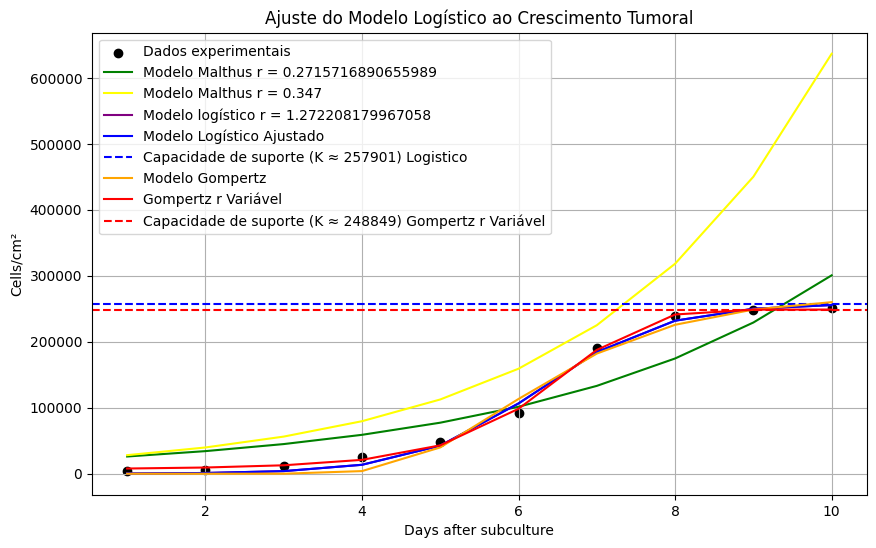

In [86]:
days = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
cells = experimental_data.iloc[:,1]

# Initial guesses for parameters
N0 = cells[0]
r0 = 0.5
K0 = max(cells)
alpha = 0.1

# Ajustando o modelo aos dados experimentais
parametros_malthus, _ = curve_fit(malthus_growth_model, days, cells, p0=[r0, N0])
parametros_malthus_r_double, _ = curve_fit(malthus_growth_model_r_double, days, cells, p0=[r0, N0])
parametros_logistic, _ = curve_fit(logistic_growth_model, days, cells, p0=[r0, N0, K0])
parametros, _ = curve_fit(modelo_logistico, days, cells, p0=[r0, N0, K0])
parametros_gompertz, _ = curve_fit(gompertz_growth_model, days, cells, p0=[r0, N0, K0], maxfev=10000)
parametros_gompertz_time_varying, _ = curve_fit(gompertz_time_varying_growth, days, cells, p0=[r0, N0, K0, alpha])

r_malthus_fit, N0_malthus_fit = parametros_malthus
r_formula_fit, N0_formula_fit = parametros_malthus_r_double
r_logistic_fit, N0_logistic_fit, K_logistic_fit = parametros_logistic
r_fit, N0_fit, K_fit = parametros
r_gompertz_fit, N0_gompertz_fit, K_gompertz_fit = parametros_gompertz
r0_tv_fit, N0_tv_fit, K_tv_fit, alpha_tv_fit = parametros_gompertz_time_varying

# Cálculo do tempo de duplicação
t_double = doubling_time(r_formula_fit)
r_double = np.log(2) / t_double
print(f"Taxa de crescimento estimada (r) para Td = {r_double:.3f} células/cm²")

# Gerando dados simulados com o modelo ajustado (previsões com 100 pontos)
t_sim = np.linspace(0, 10, 100)

N_exp = malthus_growth_model(t_sim, r_malthus_fit, N0_malthus_fit)
N_exp_r_formula = malthus_growth_model_r_double(t_sim, r_double, N0_formula_fit)
N_log = logistic_growth_model(t_sim, r_logistic_fit, N0_logistic_fit, K_logistic_fit)
N_sim = modelo_logistico(t_sim, r_fit, N0_fit, K_fit)
N_gom = gompertz_growth_model(t_sim, r_gompertz_fit, N0_gompertz_fit, K_gompertz_fit)
N_gom_tv = gompertz_time_varying_growth(t_sim, r0_tv_fit, N0_tv_fit, K_tv_fit, alpha_tv_fit)

# Interpolate simulated data to match experimental time points
N_exp_interp = interp1d(t_sim, N_exp, kind="linear")(days)
N_exp_interp_r_formula = interp1d(t_sim, N_exp_r_formula, kind="linear")(days)
N_log_interp = interp1d(t_sim, N_log, kind="linear")(days)
N_sim_interp = interp1d(t_sim, N_sim, kind="linear")(days)
N_gom_interp = interp1d(t_sim, N_gom, kind="linear")(days)
N_gom_tv_interp = interp1d(t_sim, N_gom_tv, kind="linear")(days)

modelos = ["Malthus", "Modelo Malthus com r = ln(2)/tau", "Logístico", "Gompertz", "Modelo Logístico Ajustado", "Modelo Gompertz r Variável"]
r_values = [r_malthus_fit, r_double, r_logistic_fit, r_fit, r_gompertz_fit, f"{r0_tv_fit:.3f} (inicial)"]
K_values = [None, None, K_logistic_fit, K_fit, K_gompertz_fit, K_tv_fit]
N0_values = [N0_malthus_fit, N0_formula_fit, N0_logistic_fit, N0_fit, N0_gompertz_fit, N0_tv_fit]
alpha_values = [None, None, None, None, None, alpha_tv_fit]

resultados = pd.DataFrame({
    "Modelo": modelos, 
    "r": r_values, 
    "K": K_values, 
    "N0": N0_values,
    "alpha": alpha_values
})
print(resultados)

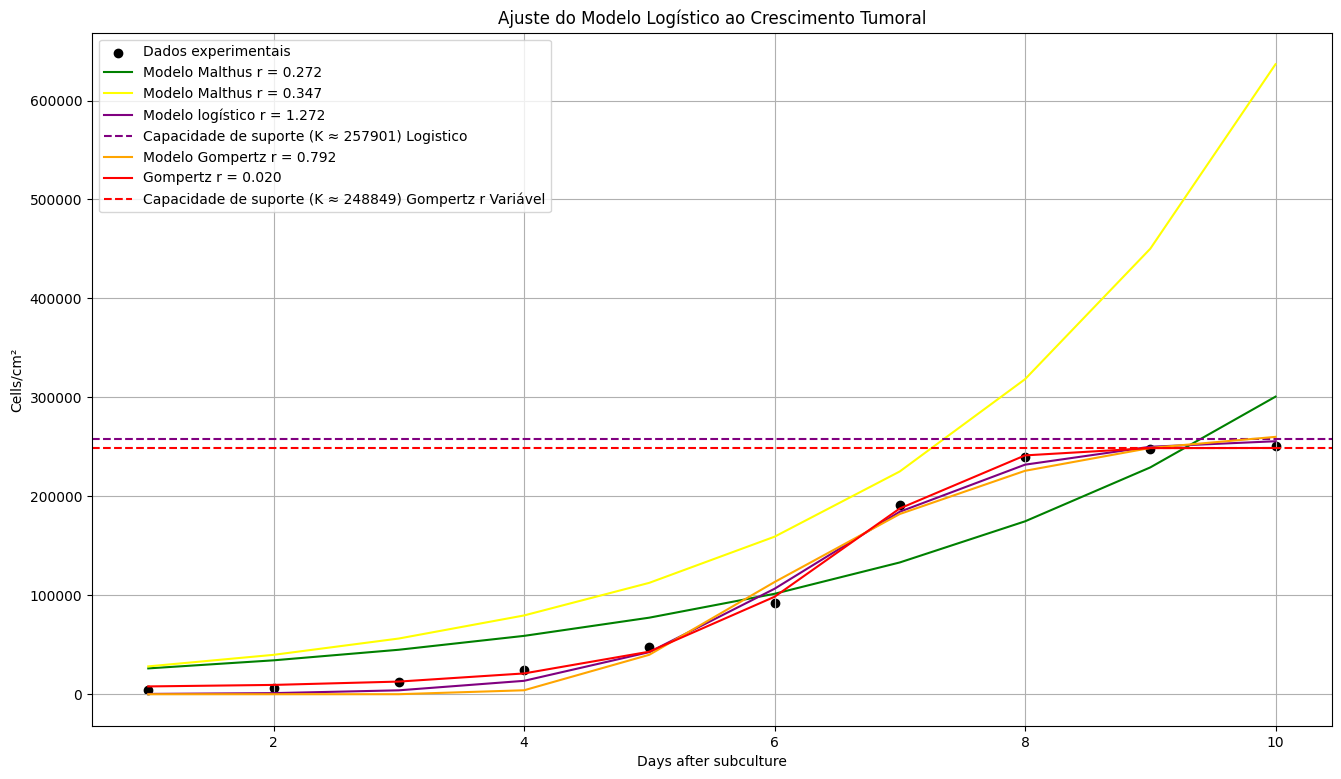

Valores ajustados para o modelo:
Taxa de crescimento estimada (r): 0.792
Capacidade de suporte estimada (K): 269763 células/cm²
População inicial estimada (N0): 0 células/cm²


In [142]:
# Plots
plt.figure(figsize=(16, 9))
plt.scatter(days, cells, label="Dados experimentais", color="black")
plt.plot(days, N_exp_interp, label=f"Modelo Malthus r = {r_malthus_fit:.3f}", color="green")
plt.plot(days, N_exp_interp_r_formula, label=f"Modelo Malthus r = {r_double:.3f}", color="yellow")
plt.plot(days, N_log_interp, label=f"Modelo logístico r = {r_logistic_fit:.3f}", color="purple")
plt.axhline(K_fit, color="purple", linestyle="dashed", label=f"Capacidade de suporte (K ≈ {int(K_logistic_fit)}) Logistico")
# plt.plot(days, N_sim_interp, label=f"Modelo Logístico Ajustado r = {r_fit:.3f}", color="blue")
plt.plot(days, N_gom_interp, label=f"Modelo Gompertz r = {r_gompertz_fit:.3f}", color="orange")
plt.plot(days, N_gom_tv_interp, label=f"Gompertz r = {r0_tv_fit:.3f}", color="red")
plt.axhline(K_tv_fit, color="red", linestyle="dashed", 
            label=f"Capacidade de suporte (K ≈ {int(K_tv_fit)}) Gompertz r Variável")
plt.xlabel("Days after subculture")
plt.ylabel("Cells/cm²")
plt.title("Ajuste do Modelo Logístico ao Crescimento Tumoral")
plt.legend()
plt.grid()
plt.savefig('ajuste_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

# Salvar os resultados em LaTeX
latex_result = df_to_latex(
    df=resultados,
    caption="Tabela de Resultados dos Modelos Ajustados",
    label="tab:resultados_modelos",
    float_format="%.3f"
)
with open('resultados_modelos.tex', 'w') as f:
    f.write(latex_result)


# Parâmetros ajustados
print(f'Valores ajustados para o modelo:')
print(f"Taxa de crescimento estimada (r): {r_gompertz_fit:.3f}")
print(f"Capacidade de suporte estimada (K): {int(K_gompertz_fit)} células/cm²")
print(f"População inicial estimada (N0): {int(N0_gompertz_fit)} células/cm²")


*AIC: (Akaike Information Criterion) é usado para comparar modelos estatísticos e penaliza modelos com mais parâmetros. O modelo com o menor AIC é o melhor ajustado aos dados.*

In [107]:

#AIC*
def AIC(y, y_pred, k):
    residuos = y - y_pred
    sse = np.sum(residuos**2)
    n = len(y)
    return n * np.log(sse/n) + 2 * k

AIC_malthus = AIC(cells, N_exp_interp, 2)
AIC_malthus_r_formula = AIC(cells, N_exp_interp_r_formula, 2)
AIC_logistic = AIC(cells, N_log_interp, 3)
AIC_proposto = AIC(cells, N_sim_interp, 3)
AIC_gompertz = AIC(cells, N_gom_interp, 3)
AIC_gompertz_tv = AIC(cells, N_gom_tv_interp, 4)

AIC_valores = [AIC_malthus, AIC_malthus_r_formula, AIC_logistic, AIC_proposto, AIC_gompertz, AIC_gompertz_tv]
resultados["AIC"] = AIC_valores
print(resultados)

                             Modelo                r              K  \
0                           Malthus         0.271572            NaN   
1  Modelo Malthus com r = ln(2)/tau         0.346574            NaN   
2                         Logístico         1.272208  257901.222005   
3                          Gompertz         1.272208  257901.222326   
4         Modelo Logístico Ajustado         0.791937  269763.001390   
5        Modelo Gompertz r Variável  0.020 (inicial)  248849.173153   

             N0     alpha         AIC  
0  1.989645e+04       NaN  215.190342  
1  1.989645e+04       NaN  241.807873  
2  8.785177e+01       NaN  185.271565  
3  8.785178e+01       NaN  185.271565  
4  6.988843e-39       NaN  194.387120  
5  7.146452e+03 -0.624617  170.685311  


In [112]:
# Modelo Gompertz com taxa variável
def gompertz_time_varying_growth(t, r0, N0, K, alpha):
    integral_r_t = (r0 / alpha) * (1 - np.exp(-alpha * t))
    return K * np.exp(np.log(N0 / K) * np.exp(-integral_r_t))

# Função de distância (erro quadrático médio)
def distance_func(exp_data, sim_data):
    return np.mean((exp_data - sim_data) ** 2)

# Distribuição inicial dos parâmetros (uniforme)
def thetas_distribution_func(limit_inf, limit_sup):
    return np.random.uniform(limit_inf, limit_sup)

# Função de perturbação dos parâmetros (não usada no ABC Rejection simples)
def perturb_func(theta, variance):
    return np.random.normal(theta, np.sqrt(variance))

# Função do kernel (não usada no ABC Rejection simples)
def kernel_func(sigma, mu, particles):
    return np.exp(-((particles - mu) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

# Método de tolerância (simplificado para ABC Rejection)
def tolerance_method(n_pop: int, tolerance_init: list, vector: list, percent: int):
    percentil_dist = np.percentile(vector, percent)
    _tolerance = np.insert(tolerance_init, n_pop, percentil_dist)
    return _tolerance

In [140]:

# Função ABC Rejection
def abc_rejection(input_values: dict, input_tolerances: dict, run_date: str, 
                  distance_func, thetas_distribution_func, perturb_func, kernel_func) -> dict:
    # Dados experimentais
    data = {
        'Tempo': [0.0108, 1.0, 2.0, 3.0, 4.0, 4.9, 5.9, 6.9, 7.8, 8.8, 9.8],
        'Valor': [4462.2, 4564.0, 6356.8, 12295.2, 24958.5, 47808.0, 
                  92459.9, 191328.1, 239610.9, 247438.8, 250635.8]
    }
    exp_data = pd.DataFrame(data)
    input_values['experimental_data'] = exp_data
    t = exp_data['Tempo'].to_numpy()
    exp_data_interp = exp_data['Valor'].to_numpy()

    # Configuração dos parâmetros
    input_values.update({
        'size': 100,
        'qtde_parameters': 4,  # r0, N0, K, alpha
        'max_populations': 1,
        'N_samples': 10000,
        't_start': 0.0,
        't_end': 10.0,
        'h': 1.0,
        'limit_inf': [0.0, 3000.0, 100000.0, -2.0],
        'limit_sup': [2.0, 6000.0, 500000.0, 2.0],
        'min_distance': float('inf'),
        'y_0': [4462.2],
        'tolerance': np.array([10000000.0]),
        'percent_value': 50,
        'distance_func': distance_func,
        'thetas_distribution_func': thetas_distribution_func,
        'num_method': None,
        'priori': 'uniform',
        'thetas_pertubed_distribution_func': perturb_func,
        'distribution_function_for_kernel': kernel_func,
        'model': gompertz_time_varying_growth,
        'multifidelity_method': None,
        'fit_compartments': [0],
        'fit_experimental': [0],
    })

    input_tolerances.update({
        'tolerance_method': tolerance_method
    })

    # Entradas
    qtde_parameters = input_values['qtde_parameters']
    max_populations = input_values['max_populations']
    size = input_values['size']
    N_samples = input_values['N_samples']
    t_start = input_values['t_start']
    t_end = input_values['t_end']
    limit_inf = input_values['limit_inf']
    limit_sup = input_values['limit_sup']
    tolerances = input_values['tolerance']
    model = input_values['model']
    N = len(t)

    # Matrizes para alocação de dados
    particles = np.zeros((max_populations, size, qtde_parameters))
    weights = np.zeros((max_populations, size, qtde_parameters))
    variances = np.zeros((max_populations, qtde_parameters))
    save_distances = np.zeros((max_populations, size))
    generated_samples = np.zeros((max_populations, size, N))
    min_sample = np.zeros(N)
    all_distances = []  # Para diagnóstico

    # ABC Rejection
    sample_count = 0
    particle_count = 0
    best_theta = None
    min_distance = input_values['min_distance']
    last_particle_index = {}

    while sample_count < N_samples and particle_count < size:
        theta = np.array([thetas_distribution_func(limit_inf[i], limit_sup[i]) 
                         for i in range(qtde_parameters)])
        sim_data = model(t, *theta)

        # Validação
        if np.any(np.isnan(sim_data)) or np.any(np.isinf(sim_data)):
            with open('invalid_thetas.txt', 'a') as f:
                f.write(f"Amostra {sample_count}: {theta}\n")
            sample_count += 1
            continue

        distance = distance_func(exp_data_interp, sim_data)
        all_distances.append(distance)

        if distance <= tolerances[0]:
            last_particle_index['initial'] = sample_count
            generated_samples[0, particle_count] = sim_data

            if distance < min_distance:
                min_distance = distance
                best_theta = theta.copy()
                min_sample = sim_data.copy()

            save_distances[0, particle_count] = distance
            particles[0, particle_count, :] = theta.copy()
            weights[0, particle_count, :] = 1 / size
            particle_count += 1
        sample_count += 1

    # Diagnósticos
    if all_distances:
        print(f"Distâncias calculadas: min={min(all_distances):.2f}, max={max(all_distances):.2f}, mean={np.mean(all_distances):.2f}")
    if particle_count == 0:
        print("Nenhuma partícula aceita. Considere aumentar a tolerância, expandir limites de parâmetros ou verificar o modelo.")

    variances[0] = np.var(particles[0], axis=0)

    # Resultados
    results = {
        'particles': particles,
        'distances': save_distances,
        'best_theta': best_theta,
        'min_distance': min_distance,
        'min_sample': min_sample,
        't': t,
        'exp_data': exp_data_interp
    }

    # Visualização
    if best_theta is not None:
        plt.figure(figsize=(10, 6))
        plt.scatter(t, exp_data_interp, label='Dados Experimentais', color='blue')
        plt.plot(t, min_sample, label=f'Melhor Ajuste (Distância = {min_distance:.2f})', color='red')
        plt.xlabel('Tempo (dias)')
        plt.ylabel('Número de Células')
        plt.title('Ajuste do Modelo Gompertz com Taxa Variável via ABC Rejection')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{run_date}_abc_rejection_fit.png')
        plt.show()
    else:
        print("Nenhum ajuste válido para plotagem. Testando modelo manualmente...")
        theta_test = [0.7, 4462.2, 248849.173153, -0.624617]
        sim_test = gompertz_time_varying_growth(t, *theta_test)
        plt.figure(figsize=(10, 6))
        plt.scatter(t, exp_data_interp, label='Dados Experimentais', color='blue')
        plt.plot(t, sim_test, label='Teste Manual (r0=0.7, N0=4462.2, K=248849, alpha=-0.624)', color='green')
        plt.xlabel('Tempo (dias)')
        plt.ylabel('Número de Células')
        plt.title('Teste Manual do Modelo Gompertz com Taxa Variável')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{run_date}_manual_test.png')
        plt.show()

    return results

Distâncias calculadas: min=193360634.13, max=144641000536.72, mean=29360171705.99
Nenhuma partícula aceita. Considere aumentar a tolerância, expandir limites de parâmetros ou verificar o modelo.
Nenhum ajuste válido para plotagem. Testando modelo manualmente...


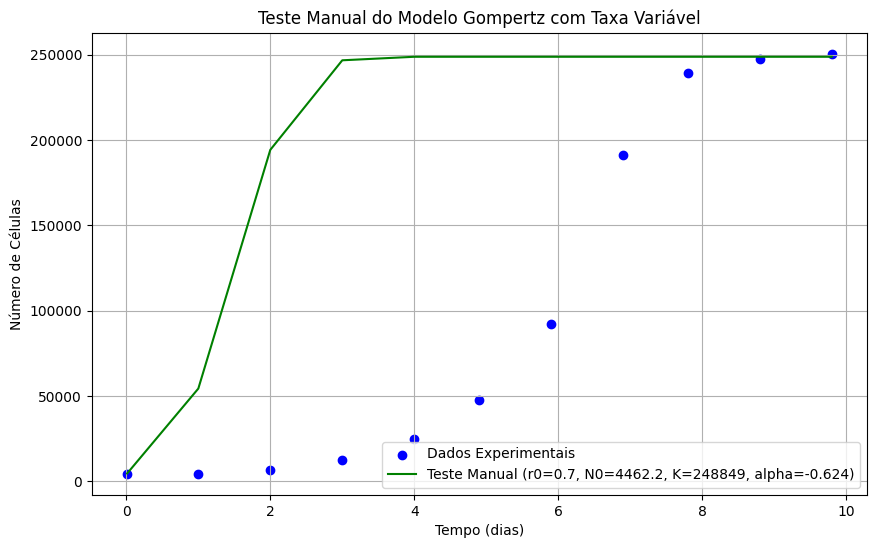

Melhor theta (r0, N0, K, alpha): None
Menor distância: inf


In [141]:
# Execução
input_values = {}
input_tolerances = {}
run_date = "2025-04-07"
results = abc_rejection(input_values, input_tolerances, run_date, distance_func, 
                       thetas_distribution_func, perturb_func, kernel_func)

# Resultados
print(f"Melhor theta (r0, N0, K, alpha): {results['best_theta']}")
print(f"Menor distância: {results['min_distance']}")